In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

#import os

In [0]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load data from google drive
train = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/train.csv')
resources = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/resources.csv')
test = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/test.csv')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## create these features for each proposal:
- total price
- highest single item price

In [0]:
resources['total_price']=resources['price']*resources['quantity'];
#if as_index=True by default, these are series; otherwise, it returns a DataFrame
#rg2=resources.groupby(by='id')['total_price'].agg('sum')#same
rg1=resources.groupby(by='id', as_index=False)['total_price'].sum();
rg2=resources.groupby(by='id',as_index=False)['price'].max();
rg2.rename({'price':'highest_single_item_price'},axis='columns',inplace=True);#rename column name
rg12=pd.merge(rg1,rg2,how='inner',on='id');

## Join the tables got from resources.csv & train.csv; resources.csv & test.csv

In [0]:
#print('Projests before 2016-05-17:',np.sum(train1['project_submitted_datetime'] < pd.Timestamp('2016-05-18')))
train1=pd.merge(train,rg12,how='left',on='id')
test1=pd.merge(test,rg12,how='left',on='id')
train1.loc[:,'project_submitted_datetime']=pd.to_datetime(train1.loc[:,'project_submitted_datetime'])
test1.loc[:,'project_submitted_datetime']=pd.to_datetime(test1.loc[:,'project_submitted_datetime'])

In [0]:
train1['project_submitted_datetime']=train1['project_submitted_datetime'].dt.date
test1['project_submitted_datetime']=test1['project_submitted_datetime'].dt.date
y_train=train1['project_is_approved']
X_train1=train1.drop(['project_is_approved'],axis=1)
X_test1=test1


## text cleaning

In [0]:
X_train1.loc[X_train1['project_essay_3'].notna(), 'new_essay_policy'] = 0 
X_train1.loc[X_train1['project_essay_3'].isna(), 'new_essay_policy'] = 1 
X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_1'] = X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_1'] + ' ' + train.loc[X_train1['project_essay_3'].notna(), 'project_essay_2']
X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_2'] = X_train1.loc[X_train1['project_essay_3'].notna(), 'project_essay_3'] + ' ' + train.loc[X_train1['project_essay_3'].notna(), 'project_essay_4']




In [0]:
X_test1.loc[X_test1['project_essay_3'].notna(), 'new_essay_policy'] = 0 
X_test1.loc[X_test1['project_essay_3'].isna(), 'new_essay_policy'] = 1 
X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_1'] = X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_1'] + ' ' + test.loc[X_test1['project_essay_3'].notna(), 'project_essay_2']
X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_2'] = X_test1.loc[X_test1['project_essay_3'].notna(), 'project_essay_3'] + ' ' + test.loc[X_test1['project_essay_3'].notna(), 'project_essay_4']



In [0]:
test1.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'total_price',
       'highest_single_item_price', 'new_essay_policy'],
      dtype='object')

In [0]:
X_train1.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)
X_test1.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [0]:
X_train1['project_essay_1'] = X_train1['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))
X_train1['project_essay_2'] = X_train1['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))


In [0]:
X_test1['project_essay_1'] = X_test1['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))
X_test1['project_essay_2'] = X_test1['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('\\', ' ').replace('  ', ' '))


## tokenize lemmatize

In [0]:
from nltk import sent_tokenize, word_tokenize

'''
def count_sent(text):
    if text == "nan" or not text:
        return 0
    sents = sent_tokenize(text)
    return len(sents)
def count_word(text):
    if text=='nan' or not text:
        return 0
    words=word_tokenize(text)
    return len(words)
# these two functions are not used
'''
X_train1['word_length_title'] = X_train1['project_title'].apply(lambda x: len(x.split()))
X_train1['word_project_essay_1'] = X_train1['project_essay_1'].apply(lambda x: len(x.split()))
X_train1['word_project_essay_2'] = X_train1['project_essay_2'].apply(lambda x: len(x.split()))

In [0]:
X_test1['word_length_title'] = X_test1['project_title'].apply(lambda x: len(x.split()))
X_test1['word_project_essay_1'] = X_test1['project_essay_1'].apply(lambda x: len(x.split()))
X_test1['word_project_essay_2'] = X_test1['project_essay_2'].apply(lambda x: len(x.split()))

In [0]:
X_train_backed = X_train1
X_test1_backed = X_test1

In [0]:
X_test1 = X_test1_backed
X_train1 = X_train_backed

## get sentiment features 

In [0]:
# functions to get polatiy and subjectivity
def get_polarity(text):
    textblob = TextBlob(text)
    pol = textblob.sentiment.polarity
    return round(pol,3)

def get_subjectivity(text):
    textblob = TextBlob(text)
    subj = textblob.sentiment.subjectivity
    return round(subj,3)
X_train1['title_polarity'] = X_train1['project_title'].apply(get_polarity)
X_train1['title_subjectivity'] = X_train1['project_title'].apply(get_subjectivity)
X_train1['essay_1_polarity'] = X_train1['project_essay_1'].apply(get_polarity)
X_train1['essay_1_subjectivity'] = X_train1['project_essay_1'].apply(get_subjectivity)
X_train1['essay_2_polarity'] = X_train1['project_essay_2'].apply(get_polarity)
X_train1['essay_2_subjectivity'] = X_train1['project_essay_2'].apply(get_subjectivity)


In [0]:
X_test1['title_polarity'] = X_test1['project_title'].apply(get_polarity)
X_test1['title_subjectivity'] = X_test1['project_title'].apply(get_subjectivity)
X_test1['essay_1_polarity'] = X_test1['project_essay_1'].apply(get_polarity)
X_test1['essay_1_subjectivity'] = X_test1['project_essay_1'].apply(get_subjectivity)
X_test1['essay_2_polarity'] = X_test1['project_essay_2'].apply(get_polarity)
X_test1['essay_2_subjectivity'] = X_test1['project_essay_2'].apply(get_subjectivity)

In [0]:

X_train1.to_csv("DonorChoose_processed_train.csv")
X_test1.to_csv("DonorChoose_processed_test.csv")

In [0]:
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [0]:
import gc
import tqdm
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def tokenize_sentences(sentences, words_dict):
    tokenized_sentences = []
    for sentence in tqdm.tqdm(sentences):
        if hasattr(sentence, "decode"):
            sentence = sentence.decode("utf-8")
        tokens = nltk.tokenize.word_tokenize(sentence)
        result = []
        for word in tokens:
            word = word.lower()
            if word not in words_dict:
                words_dict[word] = len(words_dict)
            word_index = words_dict[word]
            result.append(word_index)
        tokenized_sentences.append(result)
    return tokenized_sentences, words_dict
#embedding
def read_embedding_list(file_path):
    embedding_word_dict = {}
    embedding_list = []
    f = open(file_path, encoding="utf8")
    #f = open(file_path)
    for index, line in enumerate(f):
        if index == 0:
            continue
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embedding_list.append(coefs)
        embedding_word_dict[word] = len(embedding_word_dict)
    f.close()
    embedding_list = np.array(embedding_list)
    return embedding_list, embedding_word_dict

def clear_embedding_list(embedding_list, embedding_word_dict, words_dict):
    cleared_embedding_list = []
    cleared_embedding_word_dict = {}

    for word in words_dict:
        if word not in embedding_word_dict:
            continue
        word_id = embedding_word_dict[word]
        row = embedding_list[word_id]
        cleared_embedding_list.append(row)
        cleared_embedding_word_dict[word] = len(cleared_embedding_word_dict)

    return cleared_embedding_list, cleared_embedding_word_dict

def convert_tokens_to_ids(tokenized_sentences, words_list, embedding_word_dict, sentences_length):
    words_train = []

    for sentence in tokenized_sentences:
        current_words = []
        for word_index in sentence:
            word = words_list[word_index]
            word_id = embedding_word_dict.get(word, len(embedding_word_dict) - 2)
            current_words.append(word_id)

        if len(current_words) >= sentences_length:
            current_words = current_words[:sentences_length]
        else:
            current_words += [len(embedding_word_dict) - 1] * (sentences_length - len(current_words))
        words_train.append(current_words)
    return words_train



In [0]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras import backend as K
from keras.layers import concatenate, GRU, Input,  LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

# capsule layer

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Using TensorFlow backend.


In [0]:
UNKNOWN_WORD = "_UNK_"
END_WORD = "_END_"
NAN_WORD = "_NAN_"
CLASSES = ["project_is_approved"]

In [0]:
X_train1['application_text']=X_train1.apply(lambda row: ' '.join([
    str(row['project_title']),
    str(row['project_essay_1']),
    str(row['project_essay_2']),   
    ]),axis=1)

In [0]:
X_test1['application_text']=X_test1.apply(lambda row: ' '.join([
    str(row['project_title']),
    str(row['project_essay_1']),
    str(row['project_essay_2']),   
    ]),axis=1)

In [0]:

print("Loading data...")
X_train1_data = X_train1
list_sentences_X_train1 = X_train1_data["application_text"].fillna(NAN_WORD).values
X_test1_data = X_test1
list_sentences_X_test1 = X_test1_data["application_text"].fillna(NAN_WORD).values

y_train = y_train.values
print("Done.")

Loading data...
Done.


In [0]:
print("Tokenizing sentences in train set...")
tokenized_sentences_train, words_dict = tokenize_sentences(list_sentences_X_train1, {})
print("Tokenizing sentences in test set...")
tokenized_sentences_test, words_dict = tokenize_sentences(list_sentences_X_test1, words_dict)

  0%|          | 37/182080 [00:00<08:20, 363.58it/s]

Tokenizing sentences in train set...


  0%|          | 42/78035 [00:00<03:07, 416.22it/s]

Tokenizing sentences in test set...


100%|██████████| 78035/78035 [02:59<00:00, 433.76it/s]


In [0]:
len(words_dict)
# Embedding

embedding_path = "/content/gdrive/Shared drives/Predictive Analytics Project/Feature Engineering/crawl-300d-2M.vec"

#embedding_path = "F:/Deep Learning 2018/DonorsChoose/embeddings_small.vec"

words_dict[UNKNOWN_WORD] = len(words_dict)
print("Loading embeddings...")
embedding_list, embedding_word_dict = read_embedding_list(embedding_path)
embedding_size = len(embedding_list[0])
print("Done")

Loading embeddings...
Done


In [0]:
batch_size = 256
recurrent_units = 64
dropout_rate = 0.3 
dense_size = 32
sentences_length = 320
fold_count = 5

In [0]:
print("Preparing data...")
embedding_list, embedding_word_dict = clear_embedding_list(embedding_list, embedding_word_dict, words_dict)

embedding_word_dict[UNKNOWN_WORD] = len(embedding_word_dict)
embedding_list.append([0.] * embedding_size)
embedding_word_dict[END_WORD] = len(embedding_word_dict)
embedding_list.append([-1.] * embedding_size)

embedding_matrix = np.array(embedding_list)

id_to_word = dict((id, word) for word, id in words_dict.items())
train_list_of_token_ids = convert_tokens_to_ids(
    tokenized_sentences_train,
    id_to_word,
    embedding_word_dict,
    sentences_length)
test_list_of_token_ids = convert_tokens_to_ids(
    tokenized_sentences_test,
    id_to_word,
    embedding_word_dict,
    sentences_length)
X_train_text = np.array(train_list_of_token_ids)
X_test_text = np.array(test_list_of_token_ids)
print("Done")

Preparing data...
Done


## save intermediate model 

In [0]:
print(len(words_dict))

import pickle


def save_obj(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
    
save_obj(X_train_text,'X_train_text.pkl')
X_train1.to_csv('DonorChoose_processed_train_combined_text.csv')


142444


In [0]:
save_obj(X_test_text,'X_test_text.pkl')
X_test1.to_csv('DonorChoose_processed_test_combined_text.csv')

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class add_features(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts road name column, outputs average word length"""

    def __init__(self):
        pass #self.vars = vars  # e.g. pass in a column name to extract

    def convert_log(self, previous_proposals):#passed in is a Series?no datapoint
        #return np.mean([len(word) for word in name.split()])
        result=np.log(1+float(previous_proposals))
        #print(result)
        return result

    def transform(self, df, y=None):
        """The workhorse of this feature extractor"""
        """features about reject pressure. project viewers need to reject certain percentage
        of proposals due to limited resources. 
        This is probably a better way to use datetime info"""
        pd.options.mode.chained_assignment = None#ignore SettingWithCopyWarning because it's false positive, everything I do here is on a copy and I return a copy. if I change the names of df to df1,df2 etc, the warning should be gone.

        df.loc[:,'reject_pressure_by_funds']=df.groupby('project_submitted_datetime')['total_price'].transform(lambda x: x.sum())
        df.loc[:,'reject_pressure_by_projects']=df.groupby('project_submitted_datetime')['total_price'].transform(lambda x: x.count())
        df.loc[:,'log_previously_posted_projects']=df['teacher_number_of_previously_posted_projects'].apply(self.convert_log)
        #create DataFrames that contain categorical information
        prefix = pd.get_dummies(df['teacher_prefix'],drop_first=False)
        state=pd.get_dummies(df['school_state'],drop_first=False)
        grade= pd.get_dummies(df['project_grade_category'],drop_first=False)
        category= pd.get_dummies(df['project_subject_categories'],drop_first=False)
        #sub_category=pd.get_dummies(df['project_subject_subcategories'],drop_first=False)
        missing_cols_main=set(complete_prefix+complete_state+complete_grade+complete_category)-(set(list(prefix))|set(list(state))|set(list(grade))|set(list(category)))
        #missing_cols_extra=set(complete_sub_category)-set(list(sub_category))
        #set(complete_category)&set(complete_sub_category) not empty
        #print (missing_cols_main)
        #print (missing_cols_extra)
        df=pd.concat([df,prefix],axis=1)
        df=pd.concat([df,state],axis=1)
        df=pd.concat([df,grade],axis=1)
        df=pd.concat([df,category],axis=1)
        #df=pd.concat([df,sub_category],axis=1)
        for c1 in missing_cols_main:
            df.loc[:,c1] = 0
        #for c2 in missing_cols_extra:
        #    df.loc[:,c2] = 0
        #del prefix,state,grade,category#,sub_category
        #del missing_cols_main
        #del missing_cols_extra

        to_be_dropped_sure=['id',
         'teacher_id',
         'teacher_prefix',
         'school_state',
         'project_submitted_datetime',
         'project_grade_category',
         'project_subject_categories',
         'project_subject_subcategories',
         'project_title',
         'project_essay_1',
         'project_essay_2',
         'project_resource_summary',
         'teacher_number_of_previously_posted_projects','application_text']
        to_be_dropped=to_be_dropped_sure#+complete_prefix+complete_state+complete_grade+complete_category#+complete_sub_category
        #print(df.drop(to_be_dropped,axis=1).head(1))
        df.drop(to_be_dropped,axis=1,inplace=True)
        return df

    def fit(self, df, y=None,**fit_params):
        """Returns `self` unless something different happens in train and test"""
        return self


In [0]:
complete_prefix=list(X_train1['teacher_prefix'].dropna(axis=0, how='any').unique())
complete_state=list(X_train1['school_state'].unique())
complete_grade=list(X_train1['project_grade_category'].unique())
complete_category=list(X_train1['project_subject_categories'].unique())#51 categories
#complete_sub_category=list(X_train1['project_subject_subcategories'].unique())#407 sub-categories

X_train_nontextpart=StandardScaler().fit_transform(add_features().transform(X_train1))

In [0]:
complete_prefix=list(X_test1['teacher_prefix'].dropna(axis=0, how='any').unique())
complete_state=list(X_test1['school_state'].unique())
complete_grade=list(X_test1['project_grade_category'].unique())
complete_category=list(X_test1['project_subject_categories'].unique())#51 categories
#complete_sub_category=list(X_test1['project_subject_subcategories'].unique())#407 sub-categories

X_test_nontextpart=StandardScaler().fit_transform(add_features().transform(X_test1))

In [0]:
print(X_train_nontextpart.shape)
print(X_train_text.shape)
#print(X_test_nontextpart.shape)
X_train_formodel=np.concatenate((X_train_nontextpart,X_train_text),axis=1)
X_test_formodel=np.concatenate((X_test_nontextpart,X_test_text),axis=1)
print(X_train_formodel.shape)

(182080, 126)
(182080, 320)
(182080, 446)


In [0]:
save_obj(X_train_nontextpart,'X_train_nontextpart.pkl')
save_obj(X_train_text,'X_train_text.pkl')
save_obj(X_test_nontextpart,'X_test_nontextpart.pkl')
save_obj(X_test_text,'X_test_text.pkl')
!cp X_train_nontextpart.pkl /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/Data
!cp X_train_text.pkl /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/Data
!cp X_test_nontextpart.pkl /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/Data
!cp X_test_text.pkl /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/Data

In [0]:
X_train_nontextpart

array([[ 0.64610151, -0.09245656,  0.19046393, ..., -0.05356856,
        -0.01386579, -0.11036183],
       [-0.26586957, -0.51578444,  0.19046393, ..., -0.05356856,
        -0.01386579, -0.11036183],
       [-0.13819654,  0.94966146,  0.19046393, ..., -0.05356856,
        -0.01386579, -0.11036183],
       ...,
       [ 0.31981382,  0.2983377 ,  0.19046393, ..., -0.05356856,
        -0.01386579, -0.11036183],
       [-0.5615296 , -0.48406497,  0.19046393, ..., -0.05356856,
        -0.01386579, -0.11036183],
       [-0.37896756,  0.09971652, -5.25033804, ..., -0.05356856,
        -0.01386579, -0.11036183]])

In [0]:
def get_model(embedding_matrix, sequence_length, dropout_rate, recurrent_units, dense_size):
    
    nontext = Input(shape=[X_train_nontextpart.shape[1]], name="nontext")
    nontext1 = Dense(64, activation='relu')(nontext)
    nontext1 = Dense(128, activation='relu')(nontext1) 
    
    textpart = Input(shape=(sequence_length,),name="text")
    
    embed_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)(textpart)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x_text = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x_text)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    
    X = concatenate([
        nontext1,
        capsule,
    ])    
    
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=[nontext, textpart], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

model2=get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

model2.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 320)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 320, 300)     23672400    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 320, 300)     0           embedding_1[0][0]                
______________________________________________________________________________________

In [0]:
history_new=model2.fit([X_train_nontextpart, X_train_text], y_train, epochs=6, batch_size=256, validation_split=0.2, verbose=1)



Train on 145664 samples, validate on 36416 samples
Epoch 1/6
145664/145664 [==============================] - 717s 5ms/step - loss: 0.4023 - acc: 0.8483 - val_loss: 0.3708 - val_acc: 0.8542
Epoch 2/6
145664/145664 [==============================] - 709s 5ms/step - loss: 0.3735 - acc: 0.8531 - val_loss: 0.3629 - val_acc: 0.8573
Epoch 3/6
145664/145664 [==============================] - 706s 5ms/step - loss: 0.3649 - acc: 0.8552 - val_loss: 0.3590 - val_acc: 0.8591
Epoch 4/6
145664/145664 [==============================] - 704s 5ms/step - loss: 0.3591 - acc: 0.8566 - val_loss: 0.3590 - val_acc: 0.8580
Epoch 5/6
145664/145664 [==============================] - 707s 5ms/step - loss: 0.3545 - acc: 0.8585 - val_loss: 0.3589 - val_acc: 0.8581
Epoch 6/6
145664/145664 [==============================] - 700s 5ms/step - loss: 0.3505 - acc: 0.8598 - val_loss: 0.3580 - val_acc: 0.8575


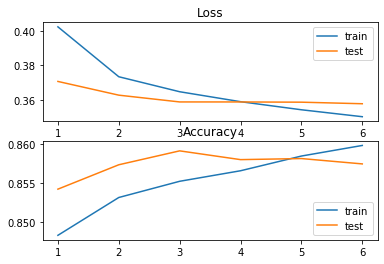

In [0]:
import matplotlib.pyplot as plt
epochs=range(1,7)
plt.subplot(211)
plt.title('Loss')
plt.plot(epochs, history_new.history['loss'], label='train')
plt.plot(epochs, history_new.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(epochs, history_new.history['acc'], label='train')
plt.plot(epochs, history_new.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
model2.save('model_new_6epochs.h5')

In [0]:
!cp model_new_6epochs.h5 /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/models

In [0]:
pred = model2.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_6epoch_4-24.csv', index=False)

RNN model2: 6epoch with class weight

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train['project_is_approved']),
                                                 train['project_is_approved'])

In [0]:
class_weights

array([3.2826134, 0.5898436])

In [0]:
model3=get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

In [0]:
history_new3=model3.fit([X_train_nontextpart, X_train_text], y_train, epochs=6, batch_size=256, validation_split=0.2, verbose=1, class_weight=class_weights)

Train on 145664 samples, validate on 36416 samples
Epoch 1/6
145664/145664 [==============================] - 479s 3ms/step - loss: 0.4041 - acc: 0.8482 - val_loss: 0.3705 - val_acc: 0.8547
Epoch 2/6
145664/145664 [==============================] - 475s 3ms/step - loss: 0.3705 - acc: 0.8533 - val_loss: 0.3651 - val_acc: 0.8567
Epoch 3/6
145664/145664 [==============================] - 474s 3ms/step - loss: 0.3628 - acc: 0.8560 - val_loss: 0.3614 - val_acc: 0.8547
Epoch 4/6
145664/145664 [==============================] - 475s 3ms/step - loss: 0.3581 - acc: 0.8575 - val_loss: 0.3737 - val_acc: 0.8462
Epoch 5/6
145664/145664 [==============================] - 478s 3ms/step - loss: 0.3544 - acc: 0.8584 - val_loss: 0.3589 - val_acc: 0.8560
Epoch 6/6
145664/145664 [==============================] - 480s 3ms/step - loss: 0.3504 - acc: 0.8599 - val_loss: 0.3652 - val_acc: 0.8528


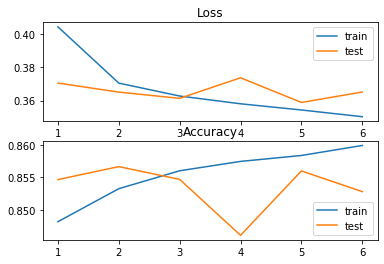

In [0]:
import matplotlib.pyplot as plt
epochs=range(1,7)
plt.subplot(211)
plt.title('Loss')
plt.plot(epochs, history_new3.history['loss'], label='train')
plt.plot(epochs, history_new3.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(epochs, history_new3.history['acc'], label='train')
plt.plot(epochs, history_new3.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
model3.save('model_new_6epochs_cw.h5')

In [0]:
!cp model_new_6epochs_cw.h5 /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/models

In [0]:
#from keras.models import load_model
#from keras.utils import CustomObjectScope
#import h5py
#model3 = load_model('/content/gdrive/Shared drives/Predictive Analytics Project/models/model_new_6epochs_cw.h5')

pred = model3.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_6epoch(cw).csv', index=False)

78035/78035 [==============================] - 98s 1ms/step


8 epochs

In [0]:
model4 = get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

In [0]:
history_new4=model4.fit([X_train_nontextpart, X_train_text], y_train, epochs=8, batch_size=256, validation_split=0.2, verbose=1)



Train on 145664 samples, validate on 36416 samples
Epoch 1/8
145664/145664 [==============================] - 488s 3ms/step - loss: 0.4088 - acc: 0.8465 - val_loss: 0.3732 - val_acc: 0.8534
Epoch 2/8
145664/145664 [==============================] - 484s 3ms/step - loss: 0.3737 - acc: 0.8529 - val_loss: 0.3633 - val_acc: 0.8563
Epoch 3/8
145664/145664 [==============================] - 484s 3ms/step - loss: 0.3636 - acc: 0.8558 - val_loss: 0.3604 - val_acc: 0.8572
Epoch 4/8
145664/145664 [==============================] - 485s 3ms/step - loss: 0.3584 - acc: 0.8577 - val_loss: 0.3605 - val_acc: 0.8589
Epoch 5/8
145664/145664 [==============================] - 487s 3ms/step - loss: 0.3541 - acc: 0.8587 - val_loss: 0.3584 - val_acc: 0.8569
Epoch 6/8
145664/145664 [==============================] - 488s 3ms/step - loss: 0.3507 - acc: 0.8596 - val_loss: 0.3604 - val_acc: 0.8563
Epoch 7/8
145664/145664 [==============================] - 489s 3ms/step - loss: 0.3473 - acc: 0.8612 - val_loss:

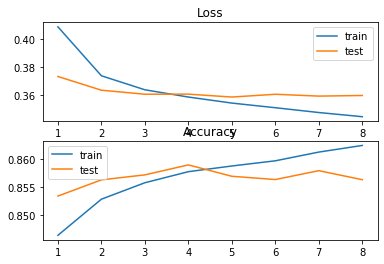

In [0]:
import matplotlib.pyplot as plt
epochs=range(1,9)
plt.subplot(211)
plt.title('Loss')
plt.plot(epochs, history_new4.history['loss'], label='train')
plt.plot(epochs, history_new4.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(epochs, history_new4.history['acc'], label='train')
plt.plot(epochs, history_new4.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
model4.save('model_new_8epochs.h5')

In [0]:
!cp model_new_8epochs.h5 /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/models

In [0]:
pred = model4.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_8epoch.csv', index=False)

78035/78035 [==============================] - 102s 1ms/step


new model with metrics of accuracy and AUC

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value


In [0]:
def get_model1(embedding_matrix, sequence_length, dropout_rate, recurrent_units, dense_size):
    
    nontext = Input(shape=[X_train_nontextpart.shape[1]], name="nontext")
    nontext1 = Dense(64, activation='relu')(nontext)
    nontext1 = Dense(128, activation='relu')(nontext1) 
    
    textpart = Input(shape=(sequence_length,),name="text")
    
    embed_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)(textpart)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)

    x_text = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x_text)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    
    X = concatenate([
        nontext1,
        capsule,
    ])    
    
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=[nontext, textpart], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', auc_roc])
    return model

In [0]:
model_auc=get_model1(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

model_auc.summary()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 320)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)

8 epochs with class weight

In [0]:
history_auc1=model_auc.fit([X_train_nontextpart, X_train_text], y_train, epochs=8, batch_size=256, validation_split=0.2, verbose=1, class_weight=class_weights)

Train on 145664 samples, validate on 36416 samples
Epoch 1/8
145664/145664 [==============================] - 523s 4ms/step - loss: 0.4070 - acc: 0.8469 - auc_roc: 0.5901 - val_loss: 0.3803 - val_acc: 0.8529 - val_auc_roc: 0.6628
Epoch 2/8
145664/145664 [==============================] - 513s 4ms/step - loss: 0.3731 - acc: 0.8526 - auc_roc: 0.6893 - val_loss: 0.3649 - val_acc: 0.8574 - val_auc_roc: 0.7077
Epoch 3/8
145664/145664 [==============================] - 508s 3ms/step - loss: 0.3651 - acc: 0.8552 - auc_roc: 0.7186 - val_loss: 0.3615 - val_acc: 0.8578 - val_auc_roc: 0.7265
Epoch 4/8
145664/145664 [==============================] - 500s 3ms/step - loss: 0.3591 - acc: 0.8575 - auc_roc: 0.7326 - val_loss: 0.3595 - val_acc: 0.8572 - val_auc_roc: 0.7379
Epoch 5/8
145664/145664 [==============================] - 498s 3ms/step - loss: 0.3540 - acc: 0.8587 - auc_roc: 0.7426 - val_loss: 0.3600 - val_acc: 0.8565 - val_auc_roc: 0.7464
Epoch 6/8
145664/145664 [=============================

In [0]:
model_auc.save('model_auc_8epochs_cw.h5')

In [0]:
!cp model_auc_8epochs_cw.h5 /content/gdrive/Shared\ drives/Predictive\ Analytics\ Project/models

In [0]:
pred = model_auc.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_8epoch(cw).csv', index=False)

78035/78035 [==============================] - 106s 1ms/step


20 epochs with early stop

In [0]:
model_auc2=get_model1(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
es = EarlyStopping(monitor='val_auc_roc',
    mode='max',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

In [0]:
history_auc2=model_auc2.fit([X_train_nontextpart, X_train_text], y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=1, callbacks = [es])



Train on 145664 samples, validate on 36416 samples
Epoch 1/20
145664/145664 [==============================] - 767s 5ms/step - loss: 0.4059 - acc: 0.8477 - auc_roc: 0.5870 - val_loss: 0.3714 - val_acc: 0.8542 - val_auc_roc: 0.6673
Epoch 2/20
145664/145664 [==============================] - 768s 5ms/step - loss: 0.3715 - acc: 0.8533 - auc_roc: 0.6959 - val_loss: 0.3631 - val_acc: 0.8559 - val_auc_roc: 0.7131
Epoch 3/20
145664/145664 [==============================] - 767s 5ms/step - loss: 0.3628 - acc: 0.8556 - auc_roc: 0.7237 - val_loss: 0.3628 - val_acc: 0.8549 - val_auc_roc: 0.7318
Epoch 4/20
145664/145664 [==============================] - 758s 5ms/step - loss: 0.3583 - acc: 0.8568 - auc_roc: 0.7377 - val_loss: 0.3580 - val_acc: 0.8579 - val_auc_roc: 0.7425
Epoch 5/20
145664/145664 [==============================] - 752s 5ms/step - loss: 0.3541 - acc: 0.8586 - auc_roc: 0.7466 - val_loss: 0.3582 - val_acc: 0.8584 - val_auc_roc: 0.7501
Epoch 6/20
145664/145664 [=====================

In [0]:
pred = model_auc2.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_20epoch.csv', index=False)

78035/78035 [==============================] - 167s 2ms/step


6 epochs with class weight and auc evaluation

In [0]:
model6=get_model1(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)


In [0]:
model6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 320)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 320, 300)     23672400    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 320, 300)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 320, 256)     329472      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
nontext (I

In [0]:
import random
from sklearn.model_selection import train_test_split
x_train = [X_train_nontextpart, X_train_text]
random.seed(5)
non_text_train, non_text_validation, text_train, text_validation, ytrain, yvalidation = train_test_split(X_train_nontextpart, 
                                                                            X_train_text, 
                                                                            y_train, 
                                                                            test_size =0.2)

In [0]:
history_new6=model6.fit([non_text_train,text_train], ytrain, epochs=6, batch_size=256, validation_split=0.2, verbose=1, class_weight=class_weights)

Train on 116531 samples, validate on 29133 samples
Epoch 1/6
116531/116531 [==============================] - 612s 5ms/step - loss: 0.4169 - acc: 0.8445 - auc_roc: 0.5636 - val_loss: 0.3850 - val_acc: 0.8496 - val_auc_roc: 0.6372
Epoch 2/6
116531/116531 [==============================] - 608s 5ms/step - loss: 0.3770 - acc: 0.8515 - auc_roc: 0.6713 - val_loss: 0.3676 - val_acc: 0.8546 - val_auc_roc: 0.6939
Epoch 3/6
116531/116531 [==============================] - 609s 5ms/step - loss: 0.3659 - acc: 0.8551 - auc_roc: 0.7076 - val_loss: 0.3638 - val_acc: 0.8551 - val_auc_roc: 0.7176
Epoch 4/6
116531/116531 [==============================] - 594s 5ms/step - loss: 0.3605 - acc: 0.8563 - auc_roc: 0.7252 - val_loss: 0.3619 - val_acc: 0.8566 - val_auc_roc: 0.7312
Epoch 5/6
116531/116531 [==============================] - 593s 5ms/step - loss: 0.3565 - acc: 0.8581 - auc_roc: 0.7361 - val_loss: 0.3644 - val_acc: 0.8579 - val_auc_roc: 0.7401
Epoch 6/6
116531/116531 [=============================

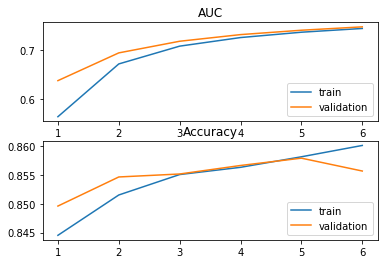

In [0]:
import matplotlib.pyplot as plt
epochs=range(1,7)
plt.subplot(211)
plt.title('AUC')
plt.plot(epochs, history_new6.history['auc_roc'], label='train')
plt.plot(epochs, history_new6.history['val_auc_roc'], label='validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(epochs, history_new6.history['acc'], label='train')
plt.plot(epochs, history_new6.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [0]:
pred6 = model6.predict([non_text_validation, text_validation], batch_size=256, verbose=1)

36416/36416 [==============================] - 76s 2ms/step


In [0]:
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
print(roc_auc_score(yvalidation,pred6, sample_weight=None))
print(classification_report(yvalidation,pred6.round()))

0.7702652499904079
              precision    recall  f1-score   support

           0       0.56      0.25      0.34      5504
           1       0.88      0.97      0.92     30912

    accuracy                           0.86     36416
   macro avg       0.72      0.61      0.63     36416
weighted avg       0.83      0.86      0.83     36416



TP 29861
TN 1354
FP 4150
FN 1051


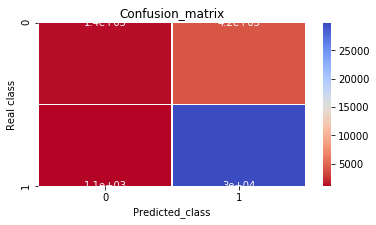

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
cnf_matrix=confusion_matrix(yvalidation,pred6.round())
fig= plt.figure(figsize=(6,3))
print("TP",cnf_matrix[1,1,])
print("TN",cnf_matrix[0,0])
print("FP",cnf_matrix[0,1])
   
print("FN",cnf_matrix[1,0])
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

In [0]:
test = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
pred = model6.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_6_77%.csv', index=False)

78035/78035 [==============================] - 159s 2ms/step


In [0]:
import pickle
def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [0]:
X_train_text2 = load_obj('/content/gdrive/Shared drives/Predictive Analytics Project/Data/X_train_text.pkl')

In [0]:
del X_train_text2

In [0]:
non_text_train, non_text_validation, text_train, text_validation, ytrain, yvalidation = train_test_split(X_train_nontextpart, 
                                                                            X_train_text2, 
                                                                            y_train, 
                                                                            test_size =0.2)

10 epochs with class weight and auc

In [0]:
model10=get_model1(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

In [0]:
history_new10=model10.fit([non_text_train,text_train], ytrain, epochs=10, batch_size=256, validation_split=0.2, verbose=1, class_weight=class_weights)

Train on 116531 samples, validate on 29133 samples
Epoch 1/10
116531/116531 [==============================] - 607s 5ms/step - loss: 0.4078 - acc: 0.8483 - auc_roc: 0.5792 - val_loss: 0.3768 - val_acc: 0.8528 - val_auc_roc: 0.6607
Epoch 2/10
116531/116531 [==============================] - 587s 5ms/step - loss: 0.3756 - acc: 0.8520 - auc_roc: 0.6893 - val_loss: 0.3769 - val_acc: 0.8519 - val_auc_roc: 0.7047
Epoch 3/10
116531/116531 [==============================] - 607s 5ms/step - loss: 0.3667 - acc: 0.8552 - auc_roc: 0.7143 - val_loss: 0.3676 - val_acc: 0.8537 - val_auc_roc: 0.7223
Epoch 4/10
116531/116531 [==============================] - 604s 5ms/step - loss: 0.3612 - acc: 0.8571 - auc_roc: 0.7285 - val_loss: 0.3620 - val_acc: 0.8566 - val_auc_roc: 0.7337
Epoch 5/10
116531/116531 [==============================] - 638s 5ms/step - loss: 0.3572 - acc: 0.8579 - auc_roc: 0.7382 - val_loss: 0.3639 - val_acc: 0.8540 - val_auc_roc: 0.7419
Epoch 6/10
116531/116531 [=======================

In [0]:
pred10 = model10.predict([non_text_validation, text_validation], batch_size=256, verbose=1)

36416/36416 [==============================] - 79s 2ms/step


In [0]:
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
print(roc_auc_score(yvalidation,pred10, sample_weight=None))
print(classification_report(yvalidation,pred10.round()))

0.7698230279634761
              precision    recall  f1-score   support

           0       0.54      0.31      0.39      5504
           1       0.89      0.95      0.92     30912

    accuracy                           0.86     36416
   macro avg       0.71      0.63      0.66     36416
weighted avg       0.83      0.86      0.84     36416



TP 30041
TN 803
FP 4876
FN 696


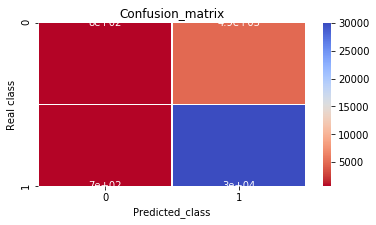

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
cnf_matrix=confusion_matrix(yvalidation,pred10.round())
fig= plt.figure(figsize=(6,3))
print("TP",cnf_matrix[1,1,])
print("TN",cnf_matrix[0,0])
print("FP",cnf_matrix[0,1])
   
print("FN",cnf_matrix[1,0])
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

In [0]:
pred = model10.predict([X_test_nontextpart, X_test_text], batch_size=256, verbose=1)
submission = pd.DataFrame({
    "id": test["id"],
    "project_is_approved": pred.reshape(-1),
})
submission.to_csv('fiddle_10epoch.csv', index=False)

78035/78035 [==============================] - 167s 2ms/step
